In [ ]:
!pip install ott-jax

In [ ]:
import numpy as onp
import jax.numpy as jnp
import jax

In [ ]:
import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

def mu_embedding(support_p, support_mu, weights_p=None, weights_mu=None, epsilon=1e-2):
  geom = pointcloud.PointCloud(support_p, support_mu, epsilon=epsilon)
  out = sinkhorn.sinkhorn(geom, weights_p, weights_mu, jit=True)
  return out.g

In [ ]:
def create_mu(num_pts_mu, dim):
  mu = onp.random.normal(loc=0., scale=1., size=(num_pts_mu, dim))
  mu = mu / (jnp.sum(mu**2, axis=-1, keepdims=True))**0.5
  radius = onp.random.uniform(low=0., high=1., size=(num_pts_mu, 1))
  radius = radius ** (1/dim)
  mu = jnp.array(mu * radius)
  return mu

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5406: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


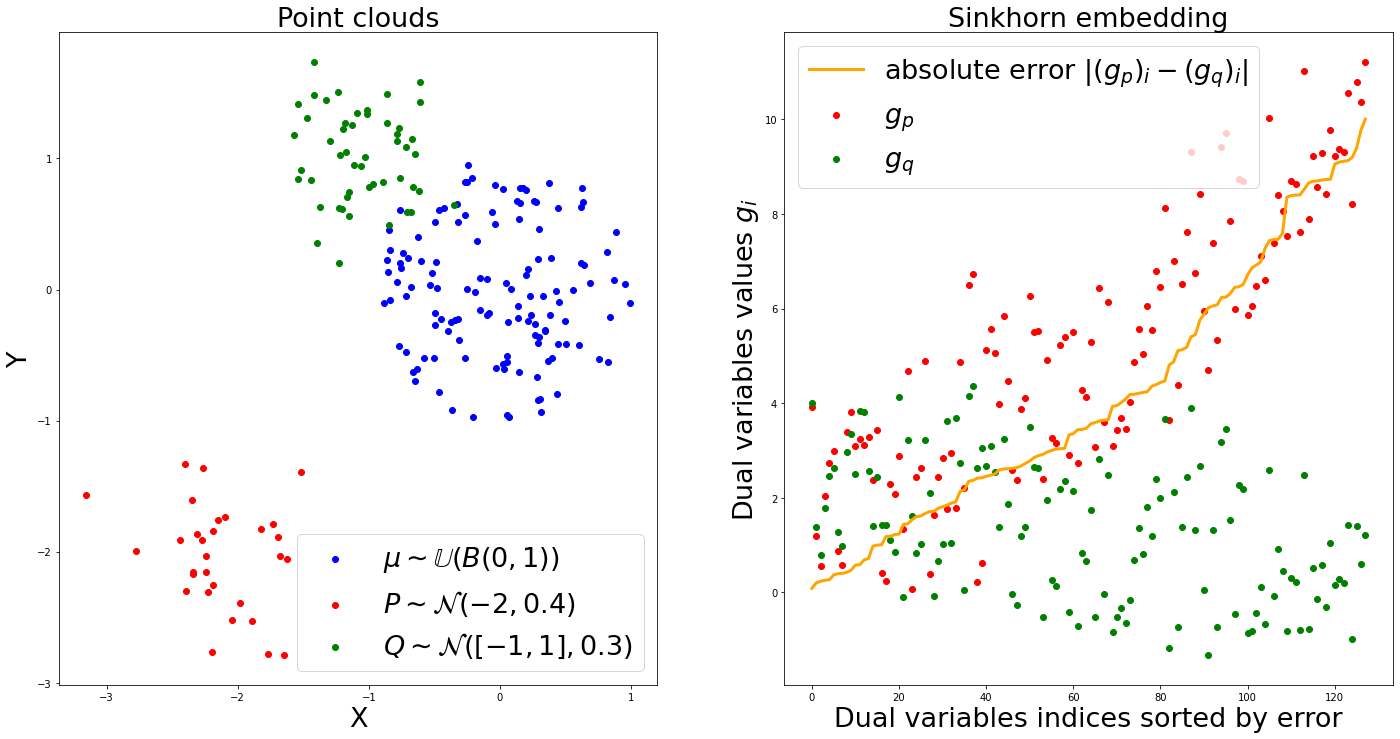

In [ ]:
import matplotlib.pyplot as plt

num_pts_mu = 128
dim = 2
mu = create_mu(num_pts_mu, dim)

num_pts_p = 30
num_pts_q = 50
p = onp.random.normal(loc=-2, scale=0.4, size=(num_pts_p, dim))
q = onp.random.normal(loc=onp.array([-1., 1.]), scale=0.3, size=(num_pts_q, dim))
g_p = mu_embedding(jnp.array(p), mu, epsilon=1e-2)
g_q = mu_embedding(jnp.array(q), mu, epsilon=1e-2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
ax1.scatter(mu[:,0], mu[:,1], c='blue', label="$\mu\sim \mathbb{U}(B(0,1))$")
ax1.scatter(p[:,0], p[:,1], c='red', label="$P\sim \mathcal{N}(-2,0.4)$")
ax1.scatter(q[:,0], q[:,1], c='green', label="$Q\sim \mathcal{N}([-1,1],0.3)$")
ax1.set_xlabel("X", fontsize=27)
ax1.set_ylabel("Y", fontsize=27)
ax1.legend(prop={'size': 27})
ax1.set_title("Point clouds", fontsize=27)
ax1.axis('scaled')

error = jnp.abs(g_p-g_q)
order = onp.argsort(error)
error = error[order]
ax2.scatter(jnp.arange(len(g_p)), g_p[order], c='red', label='$g_p$')
ax2.scatter(jnp.arange(len(g_q)), g_q[order], c='green', label='$g_q$')
plt.plot(error, c='orange', linewidth=3., label='absolute error $|(g_p)_i-(g_q)_i|$')
ax2.set_title("Sinkhorn embedding", fontsize=27)
ax2.set_xlabel("Dual variables indices sorted by error", fontsize=27)
ax2.set_ylabel("Dual variables values $g_i$", fontsize=27)
ax2.legend(prop={'size': 27})

fig.show()

In [ ]:
from tqdm import tqdm

def sinkhorn_tasks(num_tasks, dim, points_range, mean_range, scale=1., task='mean'):
  """
  Args:
    num_tasks: number of tasks to generate.
    true_mean: if True, regress the empirical mean of the sample.
               Otherwise regress the parameter that generated the distribution.
  """
  Xs, Ys = [], []
  points_range = onp.arange(points_range[0], points_range[1]+1)
  for _ in tqdm(range(num_tasks)):
    num_pts = onp.random.choice(points_range)
    mean = onp.random.uniform(mean_range[0], mean_range[1], size=dim)
    P = onp.random.normal(loc=mean, scale=scale, size=(num_pts, dim))
    X = mu_embedding(jnp.array(P), mu, epsilon=1e-2)
    if task == 'mean':
      Y = P.mean()
    elif task == 'std':
      Y = P.std()
    elif task == 'mu':
      Y = mean.mean()
    Xs.append(X)
    Ys.append(Y)
  return jnp.stack(Xs, axis=0), jnp.stack(Ys, axis=0)

In [ ]:
from collections import defaultdict
import sklearn 
from sklearn.model_selection import train_test_split, cross_validate
import sklearn.svm as svm

num_tasks = 2*1000
points_range = [100, 200]
mean_range = onp.array([-10., 10.])

mses = defaultdict(list)
dims = [2, 3, 4, 5, 8, 10]
size_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sizes = [int(num_tasks * size_ratio) for size_ratio in size_ratios]
datasets = {}
for dim in dims:
  svr = svm.SVR(kernel='rbf')
  mu = create_mu(num_pts_mu, dim)
  X, Y = sinkhorn_tasks(num_tasks, dim, points_range, mean_range, scale=1., task='mean')
  datasets[dim] = X, Y

In [ ]:
mses = defaultdict(list)
dims = [2, 3, 4, 5, 8, 10]
size_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sizes = [int(num_tasks * size_ratio) for size_ratio in size_ratios]
for dim in dims:
  X, Y = datasets[dim]
  svr = svm.SVR(kernel='rbf', C=1)
  for size in sizes:
    Xsub, Ysub = X[:size], Y[:size]
    cross_val = cross_validate(svr, Xsub, Ysub, scoring=['max_error', 'neg_mean_squared_error', 'r2'], cv=5)
    mse = -cross_val['test_neg_mean_squared_error'].mean()
    mses[dim].append(mse)

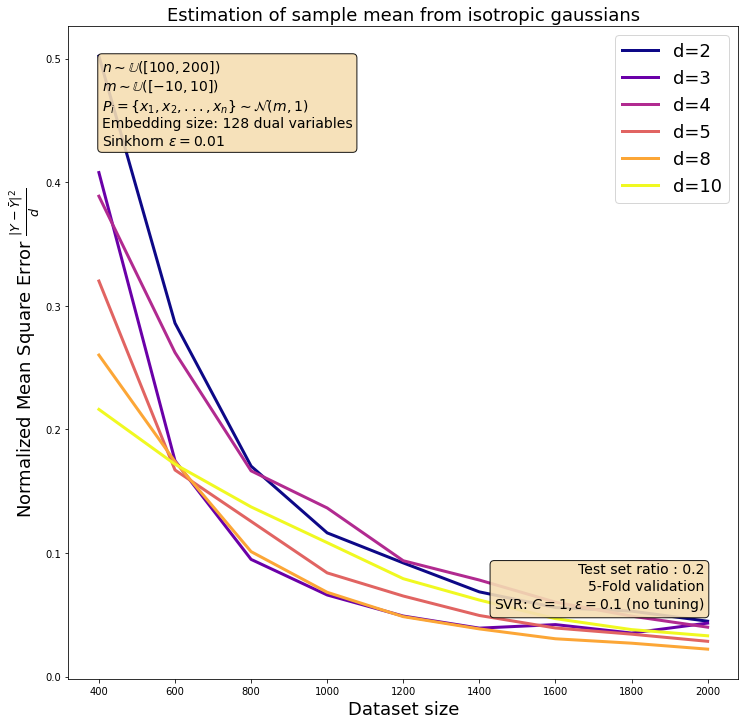

In [ ]:
plt.figure(figsize=(12, 12))
colors = plt.cm.plasma(onp.linspace(0, 1, len(dims)))
for i, dim in enumerate(dims):
  plt.plot(sizes[1:], onp.array(mses[dim][1:]) / dim, label=f'd={dim}', linewidth=3., color=colors[i])

plt.title("Estimation of sample mean from isotropic gaussians", fontsize=18)
plt.xlabel("Dataset size", fontsize=18)
plt.ylabel(r"Normalized Mean Square Error $\frac{\|Y-\bar{Y}\|^2}{d}$", fontsize=18)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
t1 = '\n'.join((r"$n\sim\mathbb{U}([100, 200])$",
                r"$m\sim\mathbb{U}([-10,10])$",
                r"$P_i=\{x_1,x_2,...,x_n\}\sim\mathcal{N}(m,1)$",
                r"Embedding size: 128 dual variables",
                r"Sinkhorn $\epsilon=0.01$"))
plt.text(0.05, 0.95, t1, fontsize=14, transform=plt.gca().transAxes,
         horizontalalignment='left', verticalalignment='top', bbox=props)
t2 = '\n'.join((r"Test set ratio : 0.2",
                r"5-Fold validation",
                r"SVR: $C=1,\epsilon=0.1$ (no tuning)"))
plt.text(0.95, 0.1, t2, fontsize=14, transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='bottom', bbox=props)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
import sklearn.metrics as metrics

def squared_euclidean_distances(X, Y):
  delta = jnp.expand_dims(X, axis=1) - jnp.expand_dims(Y, axis=0)
  return (delta**2).sum(axis=-1)

def rbf_kernel(X, Y, gamma):
  K = squared_euclidean_distances(X, Y)
  K = -gamma * K
  K = jnp.exp(K)
  return K

# @jax.jit
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    return float(XX.mean() + YY.mean() - 2 * XY.mean())

In [ ]:
def mmd_tasks(num_tasks, dim, points_range, mean_range, scale=1., task='mean'):
  Ps, Ys = [], []
  points_range = onp.arange(points_range[0], points_range[1]+1)
  for _ in tqdm(range(num_tasks)):
    num_pts = onp.random.choice(points_range)
    mean = onp.random.uniform(mean_range[0], mean_range[1], size=dim)
    P = onp.random.normal(loc=mean, scale=scale, size=(num_pts, dim))
    if task == 'mean':
      Y = P.mean()
    elif task == 'std':
      Y = P.std()
    elif task == 'mu':
      Y = mean.mean()
    Ps.append(jnp.array(P, dtype=jnp.float32))
    Ys.append(Y)
  Y = jnp.stack(Ys, axis=0)
  kernel = onp.zeros((len(Ps),len(Ps)))
  with jax.disable_jit():
    for i, p in tqdm(enumerate(Ps)):
      for j in range(i):
        q = Ps[j]
        kernel[i,j] = mmd_rbf(p, q)
        kernel[i,j] = kernel[j,i]
      kernel[i,i] = mmd_rbf(p, p)
  return kernel, Y


mses = defaultdict(list)
for dim in dims:
  svr = svm.SVR(kernel='precomputed')
  mu = create_mu(num_pts_mu, dim)
  kernel, Y = mmd_tasks(400, dim, points_range, mean_range, scale=1., task='mean')
  cross_val = cross_validate(svr, kernel, Y, scoring=['max_error', 'neg_mean_squared_error', 'r2'], cv=5)
  mse = -cross_val['test_neg_mean_squared_error'].mean()
  mses[dim].append(mse)

100%|██████████| 400/400 [00:00<00:00, 581.27it/s]
109it [29:57, 21.36s/it]

In [ ]:
plt.figure(figsize=(12, 12))
colors = plt.cm.plasma(onp.linspace(0, 1, len(dims)))
for i, dim in enumerate(dims):
  plt.plot(sizes[1:], onp.array(mses[dim][1:]) / dim, label=f'd={dim}', linewidth=3., color=colors[i])

plt.title("Estimation of sample mean from isotropic gaussians", fontsize=18)
plt.xlabel("Dataset size", fontsize=18)
plt.ylabel(r"Normalized Mean Square Error $\frac{\|Y-\bar{Y}\|^2}{d}$", fontsize=18)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
t1 = '\n'.join((r"$n\sim\mathbb{U}([100, 200])$",
                r"$m\sim\mathbb{U}([-10,10])$",
                r"$P_i=\{x_1,x_2,...,x_n\}\sim\mathcal{N}(m,1)$",
                r"Embedding: MMDD with RBF"))
plt.text(0.05, 0.95, t1, fontsize=14, transform=plt.gca().transAxes,
         horizontalalignment='left', verticalalignment='top', bbox=props)
t2 = '\n'.join((r"Test set ratio : 0.2",
                r"5-Fold validation",
                r"SVR: $C=1,\epsilon=0.1$ (no tuning)"))
plt.text(0.95, 0.1, t2, fontsize=14, transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='bottom', bbox=props)

plt.legend(loc='upper right', fontsize=18)
plt.show()